In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.experimental import CosineDecay
from keras_tuner.tuners import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
import joblib

2024-07-04 13:19:59.451003: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 13:19:59.664612: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'
tf.config.optimizer.set_jit(True)
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(4)

In [3]:
METRIC_MONITORING = 'val_loss'
METRIC_MONITORING_TUNER = 'val_accuracy'
PATIENCE = 10
EPOCHS_TRAIN = 100
EPOCHS_TUNER = 10
BATCH_SIZE = 32
TUNE_TRIALS = 25
FOLDS = 5
POLARISATION = ["W0Z0_vs_others", "W0ZT_vs_others", "WTZ0_vs_others", "WTZT_vs_others"]
WHICH_POLARISATION = 0
NAME_DNN = POLARISATION[WHICH_POLARISATION]
PATH_FIG = f'../Fig/{NAME_DNN}_TEST_3/'

optimize = True
train = True
load = not train

In [4]:
os.makedirs(PATH_FIG, exist_ok=True)

In [5]:
def load_parameters(file_path):
    parameters, limite_m, limite_p = [], [], []
    with open(file_path, "r") as file:
        for line in file:
            columns = line.split(";")
            parameters.append(columns[0])
            limite_m.append(float(columns[1]))
            limite_p.append(float(columns[2]))
    return parameters, limite_m, limite_p

parameters, limite_m, limite_p = load_parameters("/eos/user/m/mdubau/SWAN_projects/wz-dnn/variables.txt")


print("Variables")
for i in range(len(parameters)):
    print(parameters[i])
        


    
print("\n")
print("Number of parameters      : ",len(parameters))

Variables
Njets
mJJ
Deta_jj
Dphi_jj
eta_W
Pt_W
Pt_Z
Ptjet1
Etajet1
Phijet1
centrality_jet
centrality
DR_jZ
Ptjet2
MtWZ
aZylW
cosThetaZ_rec
cosThetaW_rec
RpThard2
Etajet2
Phijet2
pt1
eta1
pt2
eta2
pt3
eta3
phi1
phi2
phi3
cosThetaV_rec
WZpT_rec
MET
ZlepDPhi
WlepDPhi
Ejet1
Ejet2
pTjMean_rec
ApTj_rec
r21_rec
cosThetaVjj_rec


Number of parameters      :  41


In [6]:
def load_data(file_path, parameters):
    with uproot.open(file_path + ":ntWZVBS_SR_KinRecGen") as file_tree:
        data = file_tree.arrays(parameters + ["Weight"], library="pd")
    return np.array(data)

def load_signal_background_data(path, files_signal, files_background, parameters):
    def load_and_concatenate(files):
        data = []
        for file in files:
            data.append(load_data(path + file, parameters))
        return np.concatenate(data, axis=0)

    signal_data = load_and_concatenate(files_signal)
    background_data = load_and_concatenate(files_background)
    return signal_data, background_data

In [7]:
files_names = """
histo.run2.WZlllnu_MGPy8EG_EW_W0Z0Pol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_W0ZTPol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_WTZ0Pol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_WTZTPol_noSkim.root;
"""
files_list = [name.strip() for name in files_names.split(';') if name.strip()]

if WHICH_POLARISATION == 0:
    files_signal = [files_list[0]]
    files_background = [files_list[1], files_list[2], files_list[3]]
elif WHICH_POLARISATION == 1:
    files_signal = [files_list[1]]
    files_background = [files_list[0], files_list[2], files_list[3]]
elif WHICH_POLARISATION == 2:
    files_signal = [files_list[2]]
    files_background = [files_list[0], files_list[1], files_list[3]]
else:
    files_signal = [files_list[3]]
    files_background = [files_list[0], files_list[1], files_list[2]]


print(files_signal)
print(files_background)

signal_data, background_data = load_signal_background_data("/eos/user/m/mdubau/samples/VBS/", files_signal, files_background, parameters)

['histo.run2.WZlllnu_MGPy8EG_EW_W0Z0Pol_noSkim.root']
['histo.run2.WZlllnu_MGPy8EG_EW_W0ZTPol_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_WTZ0Pol_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_WTZTPol_noSkim.root']


In [8]:
def filter_data(data, column_index, threshold):
    indices = np.where(data[:, column_index] <= threshold)[0]
    return data[indices]

signal_data = filter_data(signal_data, parameters.index("MtWZ"), 5000)
background_data = filter_data(background_data, parameters.index("MtWZ"), 5000)

In [9]:
def prepare_data(signal_data, background_data, parameters):
    signal_label = np.ones(signal_data.shape[0])
    background_label = np.zeros(background_data.shape[0])

    X = np.concatenate((signal_data, background_data), axis=0)
    Y = np.concatenate((signal_label, background_label))

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X[:, :41])
    weights = X[:, 41] 
    
    shuffle_indices = np.random.permutation(len(Y))
    X_scaled = X_scaled[shuffle_indices]
    Y = Y[shuffle_indices]
    weights = weights[shuffle_indices]

    joblib.dump(scaler, f"../Weights/DNN3_{NAME_DNN}_TEST_scaler.save")

    return X_scaled, Y, weights

X_scaled, Y, weights = prepare_data(signal_data, background_data, parameters)

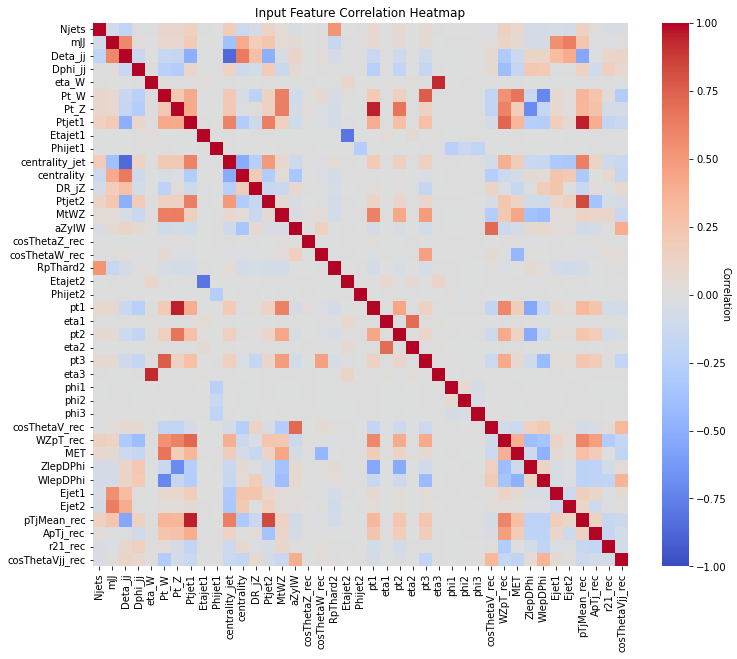

In [10]:
def plot_correlation_matrix(X_scaled, parameters, path_fig):
    non_zero_var_cols = np.var(X_scaled, axis=0) != 0
    selected_feature_names = [parameters[i] for i in range(len(parameters)) if non_zero_var_cols[i]]
    correlation_matrix = np.corrcoef(X_scaled[:, non_zero_var_cols], rowvar=False)

    plt.figure(figsize=(12, 10))
    heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f",
                          xticklabels=selected_feature_names, yticklabels=selected_feature_names, vmin=-1, vmax=1)
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Correlation', rotation=270)
    plt.xticks(rotation=90)
    plt.title('Input Feature Correlation Heatmap')
    plt.savefig(path_fig + "correlation_matrix.pdf", bbox_inches="tight")
    plt.show()

plot_correlation_matrix(X_scaled, parameters, PATH_FIG)

In [11]:
def residual_block(input_tensor, units, dropout_rate, l2_rate):
    if input_tensor.shape[-1] != units:
        input_tensor = Dense(units, activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    x = Dense(units, activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Add()([x, input_tensor])
    return x

def build_advanced_model(hp, input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(units=hp.Int('units_input', min_value=32, max_value=128, step=32),
              activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    for i in range(hp.Int('num_blocks', 1, 3)):
        x = residual_block(x, units=hp.Int(f'units_block_{i}', min_value=32, max_value=128, step=32),
                           dropout_rate=hp.Float(f'dropout_rate_block_{i}', 0.2, 0.5, step=0.1), l2_rate=0.001)

    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=AdamW(learning_rate=CosineDecay(initial_learning_rate=0.001, decay_steps=1000)),
                  loss='binary_crossentropy', metrics=['accuracy'],weighted_metrics=[])
    return model

In [12]:
def tune_model(X, Y, weights, input_dim, path_fig):
    
    tuner = BayesianOptimization(
        lambda hp: build_advanced_model(hp, input_dim),
        objective=METRIC_MONITORING_TUNER,
        max_trials=TUNE_TRIALS,
        executions_per_trial=1,
        directory='../tuner_dir',
        project_name=f'{NAME_DNN}_TEST_3'
    )
    
    tuner.search(X, Y, epochs=EPOCHS_TUNER, batch_size=BATCH_SIZE, validation_split=0.2,
             sample_weight=weights, callbacks=[EarlyStopping(monitor=METRIC_MONITORING, patience=PATIENCE)])
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters: {best_hps}")
    model = tuner.hypermodel.build(best_hps)
    return model


if optimize:
    model = tune_model(X_scaled, Y, weights, X_scaled.shape[1], PATH_FIG) 

Reloading Tuner from ../tuner_dir/W0Z0_vs_others_TEST_3/tuner0.json
Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fd5168b61f0>


In [13]:
if load:
    model = keras.models.load_model(f'../Weights/DNN3_{NAME_DNN}_TEST_weights.h5')

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 41)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  5376      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128)                  512       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 128)                  0         ['batch_normalization[0][0

Epoch 1/100


2024-07-04 13:20:23.419772: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd4b00080a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-04 13:20:23.419858: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-07-04 13:20:23.439149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-04 13:20:23.516201: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4943/4943 [==============================] - 39s 7ms/step - loss: 0.0055 - accuracy: 0.9050 - val_loss: 2.1446e-04 - val_accuracy: 0.9126 - lr: 0.0000e+00
Epoch 2/100
   1/4943 [..............................] - ETA: 49s - loss: 2.9477e-04 - accuracy: 0.8750

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4943/4943 [==============================] - 32s 7ms/step - loss: 2.1682e-04 - accuracy: 0.9097 - val_loss: 2.1446e-04 - val_accuracy: 0.9126 - lr: 0.0000e+00
Epoch 3/100
4943/4943 [==============================] - 32s 7ms/step - loss: 2.1679e-04 - accuracy: 0.9097 - val_loss: 2.1446e-04 - val_accuracy: 0.9126 - lr: 0.0000e+00
Epoch 4/100
4943/4943 [==============================] - 32s 7ms/step - loss: 2.1672e-04 - accuracy: 0.9097 - val_loss: 2.1446e-04 - val_accuracy: 0.9126 - lr: 0.0000e+00
Epoch 5/100
4943/4943 [==============================] - 33s 7ms/step - loss: 2.1673e-04 - accuracy: 0.9097 - val_loss: 2.1446e-04 - val_accuracy: 0.9126 - lr: 0.0000e+00
Epoch 6/100
4943/4943 [==============================] - 33s 7ms/step - loss: 2.1665e-04 - accuracy: 0.9097 - val_loss: 2.1446e-04 - val_accuracy: 0.9126 - lr: 0.0000e+00
Epoch 7/100
4943/4943 [==============================] - 33s 7ms/step - loss: 2.1672e-04 - accuracy: 0.9097 - val_loss: 2.1446e-04 - val_accuracy: 0.9126 - l

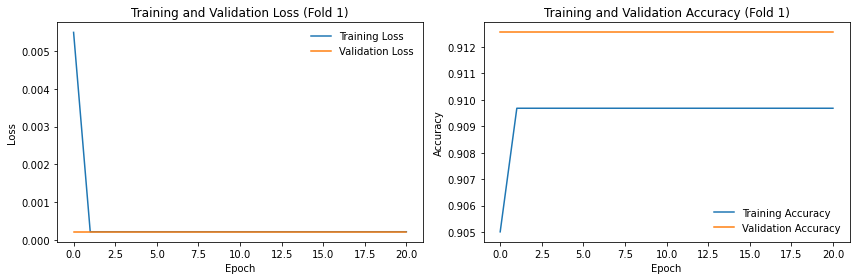

Epoch 1/100
4944/4944 [==============================] - 40s 7ms/step - loss: 2.1665e-04 - accuracy: 0.9102 - val_loss: 2.1514e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 2/100
   9/4944 [..............................] - ETA: 32s - loss: 2.4551e-04 - accuracy: 0.8993

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4944/4944 [==============================] - 36s 7ms/step - loss: 2.1675e-04 - accuracy: 0.9102 - val_loss: 2.1514e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 3/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1654e-04 - accuracy: 0.9102 - val_loss: 2.1514e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 4/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1659e-04 - accuracy: 0.9102 - val_loss: 2.1514e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 5/100
4944/4944 [==============================] - 35s 7ms/step - loss: 2.1660e-04 - accuracy: 0.9102 - val_loss: 2.1514e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 6/100
4944/4944 [==============================] - 35s 7ms/step - loss: 2.1659e-04 - accuracy: 0.9102 - val_loss: 2.1514e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 7/100
4944/4944 [==============================] - 33s 7ms/step - loss: 2.1656e-04 - accuracy: 0.9102 - val_loss: 2.1514e-04 - val_accuracy: 0.9106 - l

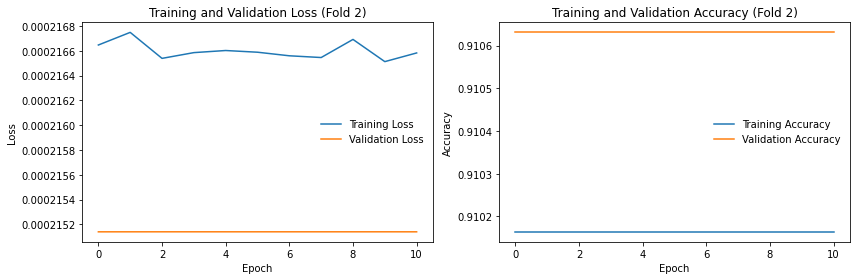

Epoch 1/100
4944/4944 [==============================] - 36s 7ms/step - loss: 2.1626e-04 - accuracy: 0.9105 - val_loss: 2.1605e-04 - val_accuracy: 0.9093 - lr: 0.0000e+00
Epoch 2/100
   9/4944 [..............................] - ETA: 31s - loss: 2.2295e-04 - accuracy: 0.9028

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4944/4944 [==============================] - 36s 7ms/step - loss: 2.1626e-04 - accuracy: 0.9105 - val_loss: 2.1605e-04 - val_accuracy: 0.9093 - lr: 0.0000e+00
Epoch 3/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1628e-04 - accuracy: 0.9105 - val_loss: 2.1605e-04 - val_accuracy: 0.9093 - lr: 0.0000e+00
Epoch 4/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1631e-04 - accuracy: 0.9105 - val_loss: 2.1605e-04 - val_accuracy: 0.9093 - lr: 0.0000e+00
Epoch 5/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1637e-04 - accuracy: 0.9105 - val_loss: 2.1605e-04 - val_accuracy: 0.9093 - lr: 0.0000e+00
Epoch 6/100
4944/4944 [==============================] - 33s 7ms/step - loss: 2.1636e-04 - accuracy: 0.9105 - val_loss: 2.1605e-04 - val_accuracy: 0.9093 - lr: 0.0000e+00
Epoch 7/100
4944/4944 [==============================] - 35s 7ms/step - loss: 2.1635e-04 - accuracy: 0.9105 - val_loss: 2.1605e-04 - val_accuracy: 0.9093 - l

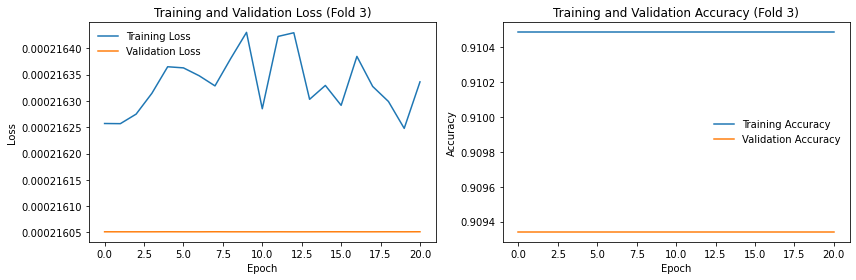

Epoch 1/100
4944/4944 [==============================] - 36s 7ms/step - loss: 2.1650e-04 - accuracy: 0.9102 - val_loss: 2.1521e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 2/100
   9/4944 [..............................] - ETA: 32s - loss: 2.4751e-04 - accuracy: 0.8785

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4944/4944 [==============================] - 35s 7ms/step - loss: 2.1652e-04 - accuracy: 0.9102 - val_loss: 2.1521e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 3/100
4944/4944 [==============================] - 35s 7ms/step - loss: 2.1665e-04 - accuracy: 0.9102 - val_loss: 2.1521e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 4/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1662e-04 - accuracy: 0.9102 - val_loss: 2.1521e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 5/100
4944/4944 [==============================] - 35s 7ms/step - loss: 2.1646e-04 - accuracy: 0.9102 - val_loss: 2.1521e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 6/100
4944/4944 [==============================] - 35s 7ms/step - loss: 2.1651e-04 - accuracy: 0.9102 - val_loss: 2.1521e-04 - val_accuracy: 0.9106 - lr: 0.0000e+00
Epoch 7/100
4944/4944 [==============================] - 36s 7ms/step - loss: 2.1654e-04 - accuracy: 0.9102 - val_loss: 2.1521e-04 - val_accuracy: 0.9106 - l

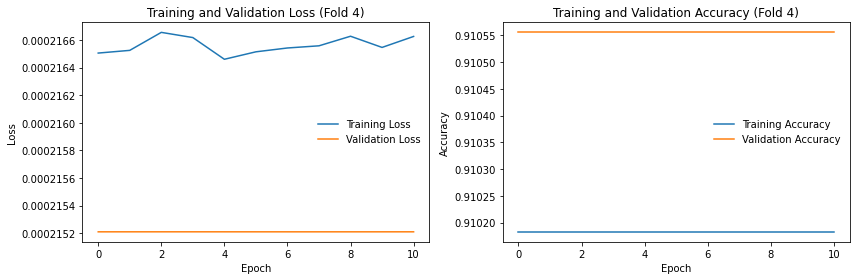

Epoch 1/100
4944/4944 [==============================] - 36s 7ms/step - loss: 2.1581e-04 - accuracy: 0.9108 - val_loss: 2.1859e-04 - val_accuracy: 0.9082 - lr: 0.0000e+00
Epoch 2/100
   9/4944 [..............................] - ETA: 31s - loss: 1.9658e-04 - accuracy: 0.9201

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4944/4944 [==============================] - 35s 7ms/step - loss: 2.1567e-04 - accuracy: 0.9108 - val_loss: 2.1859e-04 - val_accuracy: 0.9082 - lr: 0.0000e+00
Epoch 3/100
4944/4944 [==============================] - 35s 7ms/step - loss: 2.1570e-04 - accuracy: 0.9108 - val_loss: 2.1859e-04 - val_accuracy: 0.9082 - lr: 0.0000e+00
Epoch 4/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1564e-04 - accuracy: 0.9108 - val_loss: 2.1859e-04 - val_accuracy: 0.9082 - lr: 0.0000e+00
Epoch 5/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1579e-04 - accuracy: 0.9108 - val_loss: 2.1859e-04 - val_accuracy: 0.9082 - lr: 0.0000e+00
Epoch 6/100
4944/4944 [==============================] - 35s 7ms/step - loss: 2.1566e-04 - accuracy: 0.9108 - val_loss: 2.1859e-04 - val_accuracy: 0.9082 - lr: 0.0000e+00
Epoch 7/100
4944/4944 [==============================] - 34s 7ms/step - loss: 2.1581e-04 - accuracy: 0.9108 - val_loss: 2.1859e-04 - val_accuracy: 0.9082 - l

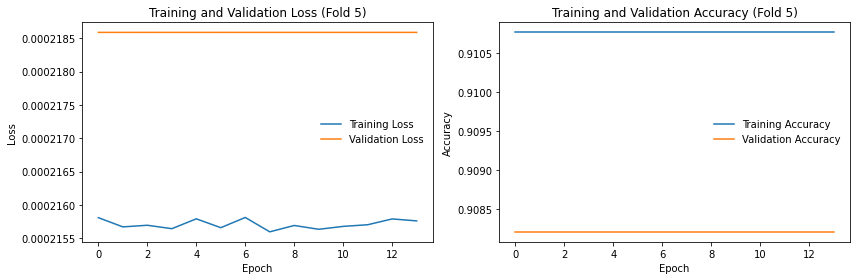

The best fold is: 1


In [15]:
def cross_validate_and_train_model(model, X, Y, weights, path_fig):
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    fold_no = 1
    best_fold = None
    best_val_accuracy = 0
    best_model_weights = None
    best_X_val = None
    best_Y_val = None
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        w_train, w_val = weights[train_index], weights[val_index]
        
        early_stopping = EarlyStopping(monitor=METRIC_MONITORING, patience=PATIENCE, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor=METRIC_MONITORING, factor=0.2, patience=2, min_lr=0.001)
        checkpoint = ModelCheckpoint(f"../Weights/DNN3_{NAME_DNN}_TEST_weights_best_fold{fold_no}.h5", monitor=METRIC_MONITORING, save_best_only=True, mode='auto')

        history = model.fit(X_train, Y_train, epochs=EPOCHS_TRAIN, batch_size=BATCH_SIZE, sample_weight=w_train,
                            validation_data=(X_val, Y_val, w_val), callbacks=[early_stopping, reduce_lr, checkpoint])
        model.save(f"../Weights/DNN3_{NAME_DNN}_TEST_weights_fold{fold_no}.h5")

        train_loss = history.history['loss']
        train_accuracy = history.history['accuracy']
        val_loss = history.history['val_loss']
        val_accuracy = history.history['val_accuracy']
        
        if max(val_accuracy) > best_val_accuracy:
            best_val_accuracy = max(val_accuracy)
            best_fold = fold_no
            best_model_weights = model.get_weights()
            best_X_val = X_val
            best_Y_val = Y_val

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title(f'Training and Validation Loss (Fold {fold_no})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(frameon=False)

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy, label='Training Accuracy')
        plt.plot(val_accuracy, label='Validation Accuracy')
        plt.title(f'Training and Validation Accuracy (Fold {fold_no})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(frameon=False)

        plt.tight_layout()
        plt.savefig(path_fig + f"loss_accuracy_fold{fold_no}.pdf", bbox_inches="tight")
        plt.show()

        fold_no += 1
    
    model.set_weights(best_model_weights)
    
    return best_fold, model, best_X_val, best_Y_val

if train:
    best_fold, best_model, X_test, Y_test = cross_validate_and_train_model(model, X_scaled, Y, weights, PATH_FIG)
    print(f'The best fold is: {best_fold}')

1236/1236 [==============================] - 5s 3ms/step - loss: 0.2970 - accuracy: 0.9126
Test Loss: 0.2970, Test Accuracy: 0.9126
1236/1236 [==============================] - 4s 3ms/step
Confusion Matrix:
[[36087     0]
 [ 3458     0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     36087
         1.0       0.00      0.00      0.00      3458

    accuracy                           0.91     39545
   macro avg       0.46      0.50      0.48     39545
weighted avg       0.83      0.91      0.87     39545

ROC-AUC Score: 0.5037


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

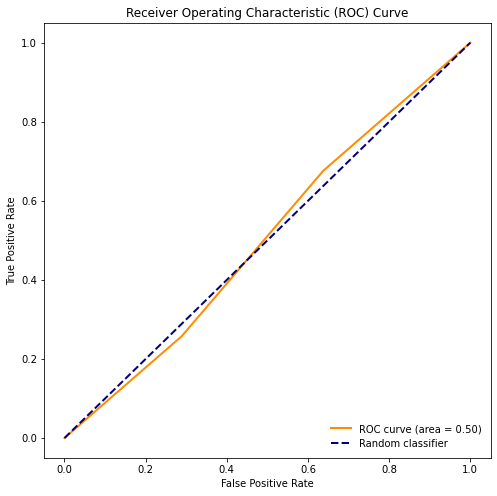

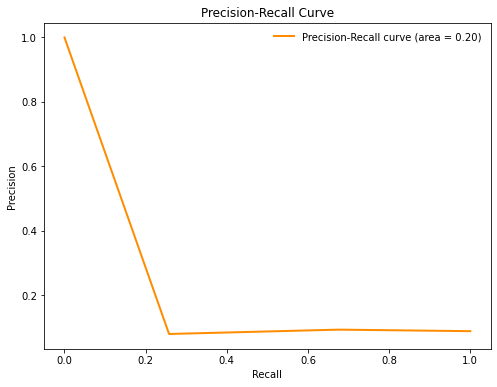

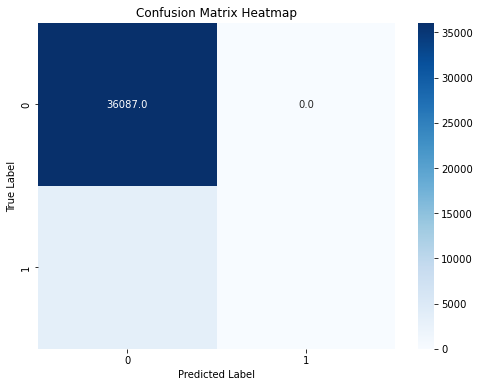

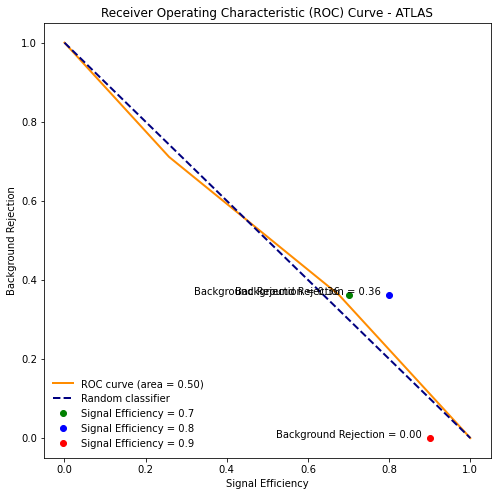

In [16]:
def evaluate_model(model, X_test, Y_test, path_fig):
    loss, accuracy = model.evaluate(X_test, Y_test)
    print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

    Y_pred = model.predict(X_test)
    Y_pred_binary = (Y_pred > 0.5).astype(int)

    conf_matrix = confusion_matrix(Y_test, Y_pred_binary)
    print("Confusion Matrix:")
    print(conf_matrix)

    class_report = classification_report(Y_test, Y_pred_binary)
    print("Classification Report:")
    print(class_report)

    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)
    print(f'ROC-AUC Score: {roc_auc:.4f}')

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right', frameon=False)
    plt.savefig(path_fig + "roc_curve.pdf")
    plt.show()

    plt.figure(figsize=(8, 6))
    precision, recall, _ = precision_recall_curve(Y_test, Y_pred)
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(auc_pr))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best', frameon=False)
    plt.savefig(path_fig + "precision_recall_curve.pdf")
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.1f', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.savefig(path_fig + "confusion_matrix.pdf")
    plt.show()



    plt.figure(figsize=(8, 8))
    plt.plot(tpr, 1 - fpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--', label="Random classifier")
    
    color = ["g","b","r"]
    for indx,i in enumerate([0.70,0.80,0.90]):
        signal_efficiency_interest = i
        index_interest = (np.abs(tpr - signal_efficiency_interest)).argmin()
    
        fpr_interest = fpr[index_interest]
        background_rejection_interest = 1 - fpr_interest
        
    
        plt.plot(signal_efficiency_interest, background_rejection_interest, 'o'+color[indx], label=f'Signal Efficiency = {i}')
    
        plt.annotate(f'Background Rejection = {background_rejection_interest:.2f}',
                     xy=(signal_efficiency_interest, background_rejection_interest),
                     xytext=(signal_efficiency_interest - 0.2, background_rejection_interest + 0.001),
                     ha='center')
    
    
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Rejection')
    plt.title('Receiver Operating Characteristic (ROC) Curve - ATLAS')
    
    
    plt.legend(loc='lower left', frameon=False)
    plt.savefig(path_fig+"roc_curve_atlas_cuts.pdf")
    plt.show()


evaluate_model(best_model, X_test, Y_test, PATH_FIG)